In [200]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
from rdkit.Chem import MolStandardize
import joblib

import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors,rdMolDescriptors
#import openpyxl


In [201]:
### Installation of the basic library 
#from openbabel import pybel 
from rdkit import Chem,DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import Crippen
import numpy as np

In [202]:
train_set=pd.read_csv('data/unique_train4_new24.csv')
test_set=pd.read_csv('data/unique_test_new24.csv')
print(train_set.shape)
print(test_set.shape)

(16626, 4)
(1282, 5)


In [180]:
### Selecting required column...
train_set=train_set[['smiles_canon','Solubility']]
test_set=test_set[['smiles_canon','Solubility']]

In [203]:
### Taking out the smiles from dataset 
smiles_train=train_set.smiles_canon
smiles_test=test_set.smiles_canon

In [204]:
### Making the smiles into the list 
smiles_list_train = smiles_train.tolist()
smiles_list_test = smiles_test.tolist()

In [205]:
functional_groups = {
        # Polar funtional group 
        'Hydroxyl Group': '[OH]',
        'Carbonyl Group': 'C=O',
        'Amide Group':'C(=O)N',
        'Carboxyl Group': 'C(=O)[OH]',
        # Non Polar funtional group 
        'Alkyl': '[R]', 
        'Aromatic Rings': 'c',
        'Alkene': 'C=C',
    }

In [206]:
### Funtion to take out the presence of funtional group with 1 and not presence with 0 
import pandas as pd
from rdkit import Chem

def get_functional_groups(smiles):
    functional_groups = {
        # Polar funtional group 
        'Hydroxyl Group': '[OH]',
        'Carbonyl Group': 'C=O',
        'Amide Group':'C(=O)N',
        'Carboxyl Group': 'C(=O)[OH]',
        # Non Polar funtional group 
        'Alkyl': '[R]', 
        'Aromatic Rings': 'c',
        'Alkene': 'C=C'
    }
    results = []
    for s in smiles:
        mol = Chem.MolFromSmiles(s)
        fg_presence = {fg: 1 if mol.HasSubstructMatch(Chem.MolFromSmarts(smarts)) else 0 for fg, smarts in functional_groups.items()}
        fg_presence['SMILES'] = s
        results.append(fg_presence)
    return results

In [207]:
def count_functional_groups(compound, functional_groups):
    group_counts = {group: 0 for group in functional_groups}
    
    for group in functional_groups:
        # Use the count method to count occurrences of the functional group in the compound
        count = compound.count(group)
        group_counts[group] = count
    return group_counts

In [208]:
### Writing a funtion to take out the funtional group from the list 
def smiles_group(smiles_list):
  functional_groups_list = get_functional_groups(smiles_list)
  df = pd.DataFrame(functional_groups_list)
  df = df[['SMILES'] + list(functional_groups.keys())]
  return df

In [209]:
### Creating a dataframe from the list with functional group 
df_train_fn=smiles_group(smiles_list_train)
df_test_fn=smiles_group(smiles_list_test)

In [210]:
df_train_fn['Solubility'] = train_set['Solubility']
df_test_fn['Solubility'] = test_set['Solubility']

In [211]:
### Saving the functional group to the disk 
df_train_fn.to_csv('data/df_train_fg.csv')
df_test_fn.to_csv('data/df_test_fg.csv') 

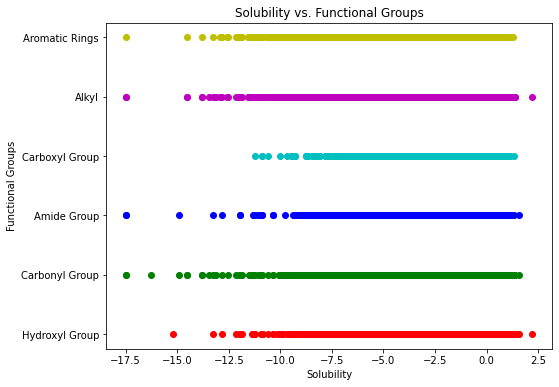

In [212]:
plt.figure(figsize=(8, 6))
for group, color in zip(functional_groups.keys(), ['r', 'g', 'b', 'c', 'm', 'y']):
    group_data = df_train_fn[df_train_fn[group] == 1]
    plt.scatter(group_data['Solubility'], [group]*len(group_data), color=color, label=group)    
plt.xlabel('Solubility')
plt.ylabel('Functional Groups')
plt.title('Solubility vs. Functional Groups')
#plt.legend()
plt.show()

In [213]:
# Create a list of functional groups

functional_groups = df_train_fn.columns[1:-1]
# Count the occurrence of each functional group
group_counts = df_train_fn[functional_groups].sum()


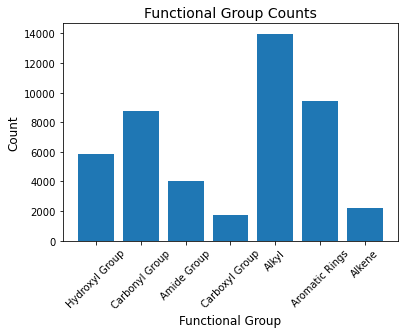

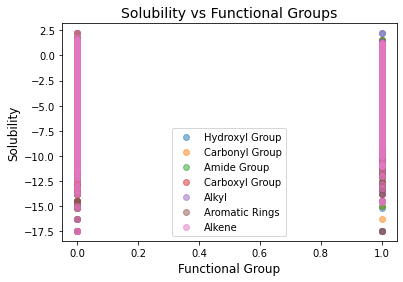

In [214]:
### Distribution of the funtional group in the train dataset along with solubility values 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df_train_fn.columns = df_train_fn.columns.astype(str)

# Compute counts of each functional group

# Plot the bar plot for functional group counts
fig, ax = plt.subplots()
ax.bar(functional_groups, group_counts)

# Customize the plot
ax.set_xlabel('Functional Group', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Functional Group Counts', fontsize=14)
ax.tick_params(axis='x', rotation=45)

# Show the bar plot
plt.show()

# Plot the scatter plot for solubility vs functional groups
fig, ax = plt.subplots()
for group in functional_groups:
    ax.scatter(df_train_fn[group], df_train_fn['Solubility'], label=group, alpha=0.5)

# Customize the plot
ax.set_xlabel('Functional Group', fontsize=12)
ax.set_ylabel('Solubility', fontsize=12)
ax.set_title('Solubility vs Functional Groups', fontsize=14)
ax.legend(fontsize=10)

# Show the scatter plot
plt.show()

<Figure size 1440x648 with 0 Axes>

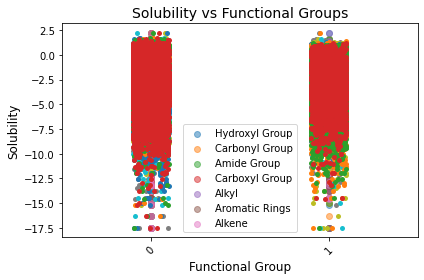

In [215]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a strip plot
plt.figure(figsize=(20,9))
handles = []  # To store legend handles
labels = []   # To store legend labels
fig, ax = plt.subplots()
for group in functional_groups:
    ax.scatter(df_train_fn[group], df_train_fn['Solubility'], label=group, alpha=0.5)
#plt.figure(figsize=(10, 6))
for group in functional_groups:
    strip = sns.stripplot(data=df_train_fn, x=df_train_fn[group], y=train_set['Solubility'], jitter=True)
    handles.append(strip.collections[1])  # Get the handle for the stripplot
    labels.append(group)

# Customize the plot
plt.xlabel('Functional Group', fontsize=12)
plt.ylabel('Solubility', fontsize=12)
plt.title('Solubility vs Functional Groups', fontsize=14)
plt.xticks(rotation=45)

# Add a legend
plt.legend(handles, labels, title='Functional Groups')
ax.legend(fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

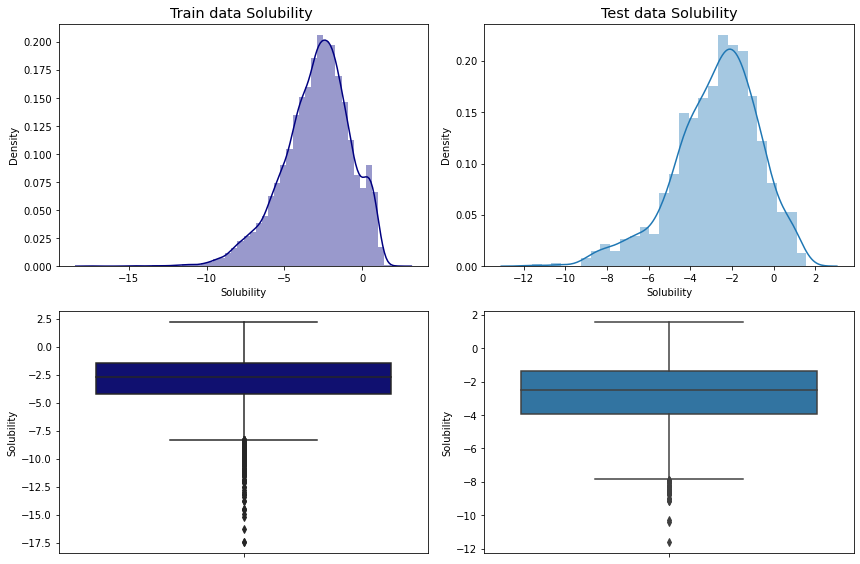

In [216]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
plt.rc('font', size=12)

# Top row - Distribution plots
sns.distplot(train_set['Solubility'], ax=axes[0, 0], color='navy')
axes[0, 0].set_title('Train data Solubility ')

sns.distplot(test_set['Solubility'], ax=axes[0, 1])
axes[0, 1].set_title('Test data Solubility')

#sns.distplot(train_set['Solubility'], ax=axes[0, 2], color='green')
#axes[0, 2].set_title('logS')

# Bottom row - Boxplots
sns.boxplot(y=train_set['Solubility'], ax=axes[1, 0], color='navy')
sns.boxplot(y=test_set['Solubility'], ax=axes[1, 1])
#sns.boxplot(y=solubility['logS'], ax=axes[1, 2],color='green')

plt.tight_layout()
plt.show()



In [217]:
from rdkit import Chem
from rdkit.Chem import Descriptors

def calculate_molecular_weight(smiles):
    """
    Calculate the molecular weight from SMILES notation.

    Args:
    - smiles (str): SMILES notation of the molecule.

    Returns:
    - mol_weight (float): Molecular weight of the molecule.
    """
    # Attempt to parse the SMILES notation and generate a molecule object
    mol = Chem.MolFromSmiles(smiles)
    
    # Check if parsing was successful
    if mol is not None:
        # Calculate the molecular weight
        mol_weight = Descriptors.MolWt(mol)
        return mol_weight
    else:
        # Return None if parsing fails
        return None


In [218]:
df_train_fn['MolecularWeight'] = df_train_fn['SMILES'].apply(calculate_molecular_weight)
df_test_fn['MolecularWeight'] = df_test_fn['SMILES'].apply(calculate_molecular_weight)



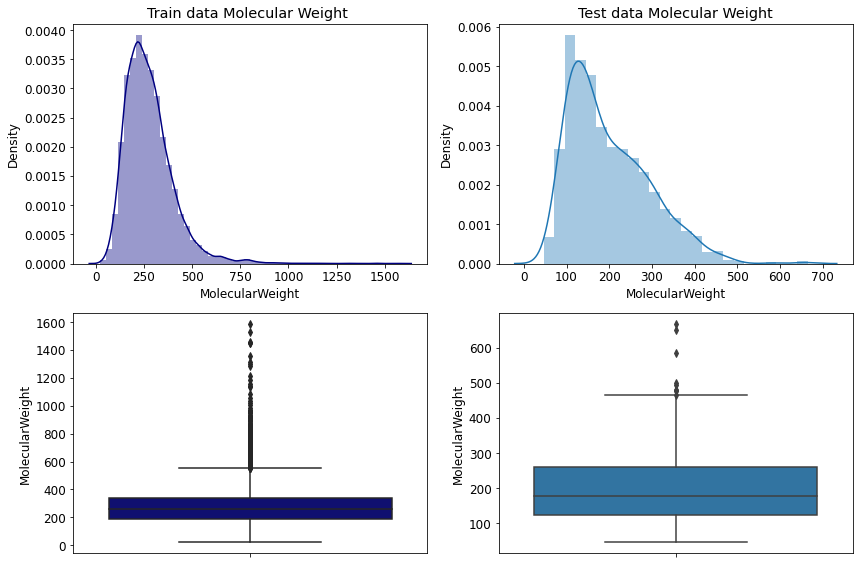

In [219]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
plt.rc('font', size=12)

# Top row - Distribution plots
sns.distplot(df_train_fn['MolecularWeight'], ax=axes[0, 0], color='navy')
axes[0, 0].set_title('Train data Molecular Weight ')

sns.distplot(df_test_fn['MolecularWeight'], ax=axes[0, 1])
axes[0, 1].set_title('Test data Molecular Weight')

#sns.distplot(train_set['Solubility'], ax=axes[0, 2], color='green')
#axes[0, 2].set_title('logS')

# Bottom row - Boxplots
sns.boxplot(y=df_train_fn['MolecularWeight'], ax=axes[1, 0], color='navy')
sns.boxplot(y=df_test_fn['MolecularWeight'], ax=axes[1, 1])
#sns.boxplot(y=solubility['logS'], ax=axes[1, 2],color='green')

plt.tight_layout()
plt.show()


### More feature engineering
### Now, we will use the information about the chemical structure of molecules available through the variable Formula to generate new features that can affect aqueous solubility of a molecule.

## Charge
## One can assume that charged molcules should have higher solubility in water since water is a polar sovent. Charged molecules contain regions with positive charge and an equal amount of negatively charged regions in order to resulting ## charge to be 0.

In [220]:
### Finding the charge in train data 
charge_train=[]

for i in range(16626):
    if train_set['smiles_canon'][i].find('+')!=-1:
        charge_train.append(1)
    elif train_set['smiles_canon'][i].find('-')!=-1:
        charge_train.append(-1)
    else:
        charge_train.append(0)
train_set['charge']=charge_train

### Finding the charge in test data 
charge_test=[]

for i in range(1282):
    if test_set['smiles_canon'][i].find('+')!=-1:
        charge_test.append(1)
    elif test_set['smiles_canon'][i].find('-')!=-1:
        charge_test.append(-1)
    else:
        charge_test.append(0)
test_set['charge']=charge_test


print('The number of charged and uncharged molecules in the Train data :')
print(train_set['charge'].value_counts())
print('The number of charged and uncharged molecules in the Test data :')
print(test_set['charge'].value_counts())


The number of charged and uncharged molecules in the Train data :
 0    13832
 1     2216
-1      578
Name: charge, dtype: int64
The number of charged and uncharged molecules in the Test data :
 0    1144
-1      93
 1      45
Name: charge, dtype: int64


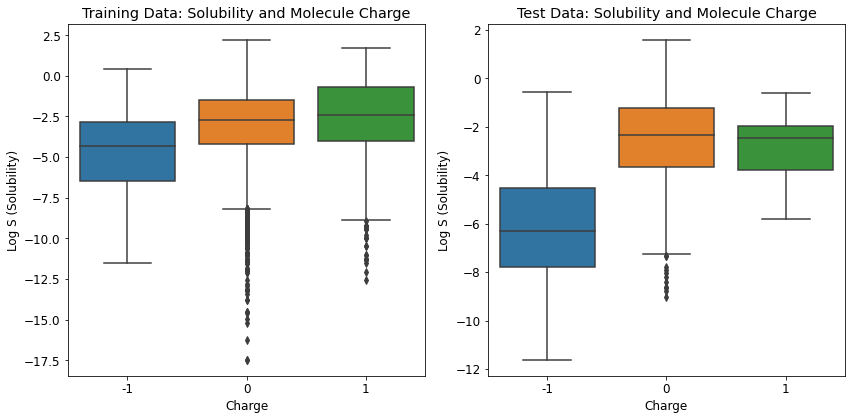

In [221]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plotting for training data
sns.boxplot(x='charge', y='Solubility', data=train_set, ax=axes[0])
axes[0].set_title('Training Data: Solubility and Molecule Charge')
axes[0].set_ylabel('Log S (Solubility)')
axes[0].set_xlabel('Charge')

# Plotting for test data
sns.boxplot(x='charge', y='Solubility', data=test_set, ax=axes[1])
axes[1].set_title('Test Data: Solubility and Molecule Charge')
axes[1].set_ylabel('Log S (Solubility)')
axes[1].set_xlabel('Charge')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [222]:
#It looks like substances' charge does not affect solubility much.
double_bonds_train=[]

for i in range(16626):
    if train_set['smiles_canon'][i].count('=')>4:
        double_bonds_train.append(1)
    else:
        double_bonds_train.append(0)
        
train_set['many_double_bonds']=double_bonds_train

double_bonds_test=[]

for i in range(1282):
    if test_set['smiles_canon'][i].count('=')>4:
        double_bonds_test.append(1)
    else:
        double_bonds_test.append(0)
        
test_set['many_double_bonds']=double_bonds_test



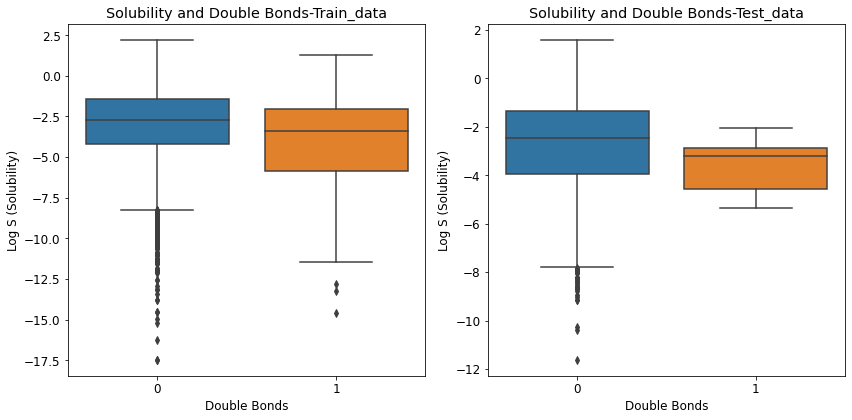

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plotting for training data
sns.boxplot(x='many_double_bonds', y='Solubility', data=train_set, ax=axes[0])
axes[0].set_title('Solubility and Double Bonds-Train_data')
axes[0].set_ylabel('Log S (Solubility)')
axes[0].set_xlabel('Double Bonds')

# Plotting for test data
sns.boxplot(x='many_double_bonds', y='Solubility', data=test_set, ax=axes[1])
axes[1].set_title('Solubility and Double Bonds-Test_data')
axes[1].set_ylabel('Log S (Solubility)')
axes[1].set_xlabel('Double Bonds')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


### We can infer that among the molecules with 5 and more double bonds, the proportion of soluble molecules is lower as compared to molecules with lower amount of double bonds.

In [133]:
def get_atom_degrees(smiles):

    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    
    bonds = mol.GetBonds()

    sum_degree_vector = np.zeros(7)

  # Iterate over each bond and retrieve the connected atom information
    for bond in bonds:
        atom1 = bond.GetBeginAtom()  # First atom in the bond
        atom2 = bond.GetEndAtom()  # Second atom in the bond

        # Create one-hot encoded vectors for atom1
        atom_degree_vector = np.array([1 if atom1.GetDegree() == d else 0 for d in range(7)]) # 7-length one-hot vector

        sum_degree_vector+=atom_degree_vector
        # Create one-hot encoded vectors for atom2
        atom_degree_vector = np.array([1 if atom2.GetDegree() == d else 0 for d in range(7)])# 7-length one-hot vector
      
        sum_degree_vector+=atom_degree_vector

    return np.round(sum_degree_vector).astype(int) # 7-length vector


In [226]:
### Removing unwanted comlumn from dataframe
train_set=train_set[['smiles_canon','Solubility','charge','many_double_bonds']]
test_set=test_set[['smiles_canon','Solubility','charge','many_double_bonds']]

In [227]:
initial_columns_train=train_set.columns.tolist()
initial_columns_test=test_set.columns.tolist()
train_set['degree_features'] = train_set['smiles_canon'].apply(lambda x: get_atom_degrees(x))
test_set['degree_features'] = test_set['smiles_canon'].apply(lambda x: get_atom_degrees(x))

atom_degree_labels=['atoms_degree_0','atoms_degree_1','atoms_degree_2','atoms_degree_3',
                    'atoms_degree_4','atoms_degree_5','atoms_degree_6']


In [151]:
def split_list_to_columns(col_name,row):
    return pd.Series(row[col_name])

In [228]:
col_name='degree_features'

# Split the "features" column and keep other columns

df_atom_degree_train = train_set.join(train_set.apply(lambda row: split_list_to_columns(col_name,row), axis=1))
df_atom_degree_test = test_set.join(test_set.apply(lambda row: split_list_to_columns(col_name,row), axis=1))

df_atom_degree_train = df_atom_degree_train.drop(col_name, axis=1)
df_atom_degree_test = df_atom_degree_test.drop(col_name, axis=1)

df_atom_degree_train.columns = initial_columns_train+atom_degree_labels
df_atom_degree_test.columns = initial_columns_test+atom_degree_labels  


In [231]:
def get_atom_valences(smiles):

    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    
    bonds = mol.GetBonds()

    sum_valence_vector = np.zeros(7)

  # Iterate over each bond and retrieve the connected atom information
    for bond in bonds:
        atom1 = bond.GetBeginAtom()  # First atom in the bond
        atom2 = bond.GetEndAtom()  # Second atom in the bond

        # Create one-hot encoded vectors for atom1
        atom_valence_vector = np.array([1 if atom1.GetTotalValence() == v else 0 for v in range(7)])  # 7-length one-hot vector

        sum_valence_vector+=atom_valence_vector
        # Create one-hot encoded vectors for atom2
        atom_valence_vector = np.array([1 if atom2.GetTotalValence() == v else 0 for v in range(7)]) # 7-length one-hot vector
      
        sum_valence_vector+=atom_valence_vector

    return np.round(sum_valence_vector).astype(int) # 7-length vector


In [232]:
initial_columns_train=df_atom_degree_train.columns.tolist()
initial_columns_test=df_atom_degree_test.columns.tolist()
df_atom_degree_train['valence_features'] = train_set['smiles_canon'].apply(lambda x: get_atom_valences(x))
df_atom_degree_test['valence_features'] = test_set['smiles_canon'].apply(lambda x: get_atom_valences(x))
atom_valence_labels=['atoms_valence_0','atoms_valence_1','atoms_valence_2','atoms_valence_3',
                    'atoms_valence_4','atoms_valence_5','atoms_valence_6']
col_name='valence_features'

# Split the "features" column and keep other columns
df_atom_valence_train = df_atom_degree_train.join(df_atom_degree_train.apply(lambda row: split_list_to_columns(col_name,row), axis=1))
df_atom_valence_test = df_atom_degree_test.join(df_atom_degree_test.apply(lambda row: split_list_to_columns(col_name,row), axis=1))

df_atom_valence_train = df_atom_valence_train.drop(col_name, axis=1)
df_atom_valence_test = df_atom_valence_test.drop(col_name, axis=1)

df_atom_valence_train.columns = initial_columns_train+atom_valence_labels
df_atom_valence_test.columns = initial_columns_test+atom_valence_labels  



In [233]:
hybridizations = [Chem.rdchem.HybridizationType.S, Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2, Chem.rdchem.HybridizationType.SP3,
                  Chem.rdchem.HybridizationType.SP3D, Chem.rdchem.HybridizationType.SP3D2, Chem.rdchem.HybridizationType.UNSPECIFIED]


In [234]:
def get_atom_hybridization(smiles):

    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    
    bonds = mol.GetBonds()

    sum_hybrid_vector = np.zeros(7)

  # Iterate over each bond and retrieve the connected atom information
    for bond in bonds:
        atom1 = bond.GetBeginAtom()  # First atom in the bond
        atom2 = bond.GetEndAtom()  # Second atom in the bond

        # Create one-hot encoded vectors for atom1
        atom_hybrid_vector = np.array([1 if atom1.GetHybridization() == h else 0 for h in hybridizations])  # 7-length one-hot vector

        sum_hybrid_vector+=atom_hybrid_vector
        # Create one-hot encoded vectors for atom2
        atom_hybrid_vector = np.array([1 if atom2.GetHybridization() == h else 0 for h in hybridizations]) # 7-length one-hot vector
      
        sum_hybrid_vector+=atom_hybrid_vector

    return np.round(sum_hybrid_vector).astype(int) # 7-length vector



In [235]:
initial_columns_train=df_atom_valence_train.columns.tolist()
initial_columns_test=df_atom_valence_test.columns.tolist()
df_atom_valence_train['hybridization_features'] = df_atom_valence_train['smiles_canon'].apply(lambda x: get_atom_hybridization(x))
df_atom_valence_test['hybridization_features'] = df_atom_valence_test['smiles_canon'].apply(lambda x: get_atom_hybridization(x))
hybridization_labels=['atom_hybridization_S','atom_hybridization_SP','atom_hybridization_SP2',
                      'atom_hybridization_SP3','atom_hybridization_SP3D','atom_hybridization_SP3D2',
                      'atom_hybridization_UNSPECIFIED']

In [236]:
col_name='hybridization_features'

# Split the "features" column and keep other columns
df_atom_hybridization_train = df_atom_valence_train.join(df_atom_valence_train.apply(lambda row: split_list_to_columns(col_name,row), axis=1))
df_atom_hybridization_test = df_atom_valence_test.join(df_atom_valence_test.apply(lambda row: split_list_to_columns(col_name,row), axis=1))

df_atom_hybridization_train = df_atom_hybridization_train.drop(col_name, axis=1)
df_atom_hybridization_test = df_atom_hybridization_test.drop(col_name, axis=1)

df_atom_hybridization_train.columns = initial_columns_train+hybridization_labels 
df_atom_hybridization_test.columns = initial_columns_test+hybridization_labels 


In [237]:
def get_atom_aromaticity(smiles):

    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    
    bonds = mol.GetBonds()

    sum_aromatic_vector = np.zeros(1)

  # Iterate over each bond and retrieve the connected atom information
    for bond in bonds:
        atom1 = bond.GetBeginAtom()  # First atom in the bond
        atom2 = bond.GetEndAtom()  # Second atom in the bond

        # Create one-hot encoded vectors for atom1
        atom_aromatic_vector = np.array([1 if atom1.GetIsAromatic() else 0]) # 1-length one-hot vector

        sum_aromatic_vector+=atom_aromatic_vector
        # Create one-hot encoded vectors for atom2
        atom_aromatic_vector = np.array([1 if atom2.GetIsAromatic() else 0])# 1-length one-hot vector
      
        sum_aromatic_vector+=atom_aromatic_vector

    return np.round(sum_aromatic_vector).astype(int)[0] # number 0 or 1


In [238]:
df_atom_hybridization_train['aromatic_atoms'] = df_atom_hybridization_train['smiles_canon'].apply(lambda x: get_atom_aromaticity(x))
df_atom_aromaticity_train=df_atom_hybridization_train.copy()
df_atom_hybridization_test['aromatic_atoms'] = df_atom_hybridization_test['smiles_canon'].apply(lambda x: get_atom_aromaticity(x))
df_atom_aromaticity_test=df_atom_hybridization_test.copy()

In [239]:
## Bond Types 
def get_bond_types(smiles):

    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    
    bonds = mol.GetBonds()

    sum_bond_type_vector = np.zeros(5)

  # Iterate over each bond and retrieve the connected atom information
    for bond in bonds:
        
        bond_type = bond.GetBondType().name
        
        bond_type_vector = np.array([1 if t == bond_type else 0 for t in ['SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC', 'ZERO']])# 5-length one-hote vector
        
        sum_bond_type_vector+=bond_type_vector

    return np.round(sum_bond_type_vector).astype(int) 


In [240]:
initial_columns_train=df_atom_aromaticity_train.columns.tolist()
initial_columns_test=df_atom_aromaticity_test.columns.tolist()
df_atom_aromaticity_train['bond_type_features'] = df_atom_aromaticity_train['smiles_canon'].apply(lambda x: get_bond_types(x))
df_atom_aromaticity_test['bond_type_features'] = df_atom_aromaticity_test['smiles_canon'].apply(lambda x: get_bond_types(x))
bond_type_labels=['single_bonds','double_bonds','triple_bonds','aromatic_bonds','zero_bonds']
col_name='bond_type_features'

# Split the "features" column and keep other columns
df_bond_type_train = df_atom_aromaticity_train.join(df_atom_aromaticity_train.apply(lambda row: split_list_to_columns(col_name,row), axis=1))
df_bond_type_test = df_atom_aromaticity_test.join(df_atom_aromaticity_test.apply(lambda row: split_list_to_columns(col_name,row), axis=1))



df_bond_type_train = df_bond_type_train.drop(col_name, axis=1)
df_bond_type_test = df_bond_type_test.drop(col_name, axis=1)

df_bond_type_train.columns = initial_columns_train+bond_type_labels 
df_bond_type_test.columns = initial_columns_test+bond_type_labels


In [242]:
#Conjugated bonds
def is_conjugated(smiles):
    
    
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    # Get all bonds in the molecule
    bonds = mol.GetBonds()
    
    sum_conjugated = np.zeros(1)
    
    for bond in bonds:
        
        is_conjugated=1 if bond.GetIsConjugated() else 0
        conjugation_vector = np.array([is_conjugated])
        
        sum_conjugated+=conjugation_vector
        
    return np.round(sum_conjugated).astype(int)[0]


In [243]:
df_bond_type_train['conjugated_bonds'] = df_bond_type_train['smiles_canon'].apply(lambda x: is_conjugated(x))
df_conjugated_bonds_train=df_bond_type_train.copy()
df_bond_type_test['conjugated_bonds'] = df_bond_type_test['smiles_canon'].apply(lambda x: is_conjugated(x))
df_conjugated_bonds_test=df_bond_type_test.copy()

In [244]:
##Bonds in ring
def is_in_ring(smiles):
    
    
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    # Get all bonds in the molecule
    bonds = mol.GetBonds()
    
    sum_in_ring = np.zeros(1)
    
    for bond in bonds:
        
        is_in_ring=1 if bond.IsInRing() else 0
        in_ring_vector = np.array([is_in_ring])
        
        sum_in_ring+=in_ring_vector
        
    return np.round(sum_in_ring).astype(int)[0]



In [245]:
df_conjugated_bonds_train['bonds_in_ring'] = df_conjugated_bonds_train['smiles_canon'].apply(lambda x: is_in_ring(x))
df_bonds_in_ring_train=df_conjugated_bonds_train.copy()
df_conjugated_bonds_test['bonds_in_ring'] = df_conjugated_bonds_test['smiles_canon'].apply(lambda x: is_in_ring(x))
df_bonds_in_ring_test=df_conjugated_bonds_test.copy()

In [246]:
#Bond chirality
#The bond.GetStereo() method typically returns one of the following values:

#Chem.rdchem.BondStereo.STEREONONE: This indicates that the bond has no defined stereochemistry, meaning there is no specific spatial arrangement of substituents around the bond that results in different stereoisomers.

#Chem.rdchem.BondStereo.STEREOANY: This indicates that the bond is considered a stereo bond, but its stereochemistry is not specified. It means that the bond could potentially have stereoisomers, but their configurations are not defined or are flexible.

#Chem.rdchem.BondStereo.STEREOZ and Chem.rdchem.BondStereo.STEREOE: These values are used to specify the stereochemistry of double bonds (alkene bonds).

#STEREOZ indicates a "cis" configuration where substituents on the same side of the double bond. STEREOE indicates a "trans" configuration where substituents are on opposite sides of the double bond.

def get_bond_chirality(smiles):
    
    
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)

    # Get all bonds in the molecule
    bonds = mol.GetBonds()
    
    sum_chirality = np.zeros(4)
    
    for bond in bonds:
        
        # Chirality (0: None, 1: CW, 2: CCW, 3: Either)
        chirality = bond.GetStereo()
        
        chirality_vector=np.array([1 if chirality == c else 0 for c in [Chem.rdchem.BondStereo.STEREONONE,
                                                                          Chem.rdchem.BondStereo.STEREOANY,
                                                                          Chem.rdchem.BondStereo.STEREOZ,
                                                                          Chem.rdchem.BondStereo.STEREOE]])
        
        sum_chirality+=chirality_vector
        
    return np.round(sum_chirality).astype(int)
  


In [247]:
initial_columns_train=df_bonds_in_ring_train.columns.tolist()
initial_columns_test=df_bonds_in_ring_test.columns.tolist()

In [248]:
initial_columns_train=df_bonds_in_ring_train.columns.tolist()
initial_columns_test=df_bonds_in_ring_test.columns.tolist()
df_bonds_in_ring_train['chirality_features'] = df_bonds_in_ring_train['smiles_canon'].apply(lambda x: get_bond_chirality(x))
df_bonds_in_ring_test['chirality_features'] = df_bonds_in_ring_test['smiles_canon'].apply(lambda x: get_bond_chirality(x))
chirality_labels=['chirality_none','chirality_any','chirality_z','chirality_e']
col_name='chirality_features'

# Split the "features" column and keep other columns
df_bond_chirality_train = df_bonds_in_ring_train.join(df_bonds_in_ring_train.apply(lambda row: split_list_to_columns(col_name,row), axis=1))
df_bond_chirality_test = df_bonds_in_ring_test.join(df_bonds_in_ring_test.apply(lambda row: split_list_to_columns(col_name,row), axis=1))

df_bond_chirality_train= df_bond_chirality_train.drop(col_name, axis=1)
df_bond_chirality_test= df_bond_chirality_test.drop(col_name, axis=1)

df_bond_chirality_train.columns = initial_columns_train+chirality_labels 
df_bond_chirality_test.columns = initial_columns_test+chirality_labels 

In [249]:
#Number of atoms
def get_n_atoms(smiles):
    
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    
    n_atoms=mol.GetNumAtoms()
    
    return n_atoms 
def get_n_bonds(smiles):
    
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    
    n_bonds=mol.GetNumBonds()
    
    return n_bonds    

In [250]:
df_final_train=df_bond_chirality_train.copy()
df_final_test=df_bond_chirality_test.copy()
df_final_train['n_atoms']=df_final_train['smiles_canon'].apply(lambda x: get_n_atoms(x))
df_final_test['n_atoms']=df_final_test['smiles_canon'].apply(lambda x: get_n_atoms(x))
#Number of bonds
def get_n_bonds(smiles):
    
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    
    n_bonds=mol.GetNumBonds()
    
    return n_bonds
df_final_train['n_bonds']=df_final_train['smiles_canon'].apply(lambda x: get_n_bonds(x))
df_final_test['n_bonds']=df_final_test['smiles_canon'].apply(lambda x: get_n_bonds(x))


In [251]:
#Number of rings
#'Chem.GetSymmSSSR(mol): This function, GetSymmSSSR, is used to identify and retrieve the symmetrically distinct smallest set of smallest rings in a molecule (mol). SSSR refers to a collection of rings in a molecule where each ring is as small as possible and where no two rings share an identical set of atoms.

#len(...): This is the Python len function, which is used to determine the length (i.e., the number of elements) of a given sequence or container, in this case, the list of symmetrically distinct rings returned by Chem.GetSymmSSSR(mol).

#So, len(Chem.GetSymmSSSR(mol)) calculates and returns the count of symmetrically distinct rings in the molecule mol. This information can be useful for understanding the molecular structure, aromaticity, and other properties of the molecule, as rings play a significant role in organic chemistry and chemical analysis.

def get_n_rings(smiles):
    
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    
    n_rings=len(Chem.GetSymmSSSR(mol))
    
    return n_rings
df_final_train['n_rings']=df_final_train['smiles_canon'].apply(lambda x: get_n_rings(x))
df_final_test['n_rings']=df_final_test['smiles_canon'].apply(lambda x: get_n_rings(x))


In [254]:
df_final_train_copy = df_final_train.copy()
df_final_test_copy = df_final_test.copy()


In [256]:
df_final_train

,smiles_canon,Solubility,charge,many_double_bonds,atoms_degree_0,atoms_degree_1,atoms_degree_2,atoms_degree_3,atoms_degree_4,atoms_degree_5,...,zero_bonds,conjugated_bonds,bonds_in_ring,chirality_none,chirality_any,chirality_z,chirality_e,n_atoms,n_bonds,n_rings
0,O=C1c2ccccc2C(=O)c2c(Cl)cccc21,-5.540000,0,0,0,10,0,42,0,0,...,0,18,16,26,0,0,0,24,26,3
1,NC(N)=NS(=O)(=O)c1ccc(N)cc1,-1.984970,0,0,0,12,2,30,4,0,...,0,10,6,24,0,0,0,24,24,1
2,CCC1C(N)CN1c1cc2c(cc1F)c(=O)c(C(=O)O)cn2C1CC1,-3.912000,0,0,0,23,2,39,32,0,...,0,16,18,48,0,0,0,45,48,4
3,CCC1(CC)OC(=O)c2cc([N+](=O)[O-])ccc21,-3.656000,1,0,0,16,2,24,20,0,...,0,12,10,31,0,0,0,30,31,2
4,O=C1C=Cc2ccccc2C1=NO,-2.937000,0,0,0,8,4,30,0,0,...,0,14,11,21,0,0,0,20,21,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16621,c1cnoc1,0.383095,0,0,0,3,4,9,0,0,...,0,5,5,8,0,0,0,8,8,1
16622,c1coc(-c2nc3ccccc3[nH]2)c1,-3.414016,-1,0,0,8,4,36,0,0,...,0,16,15,24,0,0,0,22,24,3
16623,c1nc[nH]n1,0.897170,0,0,0,3,4,9,0,0,...,0,5,5,8,0,0,0,8,8,1
16624,c1ncc2[nH]cnc2n1,0.619695,0,0,0,4,6,18,0,0,...,0,10,10,14,0,0,0,13,14,2


In [258]:
### Save the train and test data with feature engineered properties of the compounds. 
df_final_train.to_csv('data/df_train_fe.csv')
df_final_test.to_csv('data/df_test_fe.csv') 